In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import pickle
# with open('/content/drive/My Drive/data_sets_ct/lung_cancer_train.pkl', 'rb') as f:
#     data = pickle.load(f)

# **Libraries**

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import os
import matplotlib.pylab as plt

First Approach: (Success)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(512, 512))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        img_name = f'{index}.png'
        img_path = os.path.join(self.image_paths, img_name)
        mask_path = os.path.join(self.target_paths, img_name)  # Assuming mask files have the same name as image files with "_mask" suffix

        image = Image.open(img_path)
        mask = Image.open(mask_path)
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(os.listdir(self.image_paths))

Second Approach: (Fail)

In [ ]:
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(256),  # Randomly crop images to 224x224
#     transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
#     transforms.ToTensor(),              # Convert images to PyTorch tensors
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize image tensors
# ])

# class ImageDataset(Dataset):
#     def __init__(self, image_folder, mask_folder, transform=None):
#         self.image_folder = image_folder
#         self.mask_folder = mask_folder
#         self.image_files = os.listdir(image_folder)
#         self.transform = transform


#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = f'{idx}.jpg'
#         img_path = os.path.join(self.image_folder, img_name)
#         mask_path = os.path.join(self.mask_folder, img_name)  # Assuming mask files have the same name as image files with "_mask" suffix

#         image = Image.open(img_path)
#         mask = Image.open(mask_path)

#         if self.transform:
#             image = self.transform(image)
#             mask = self.transform(mask)

#         return image, mask

# **Model**

This model is not working yet

In [ ]:
# import torchvision.models as models

# class MobileNetV2UNet(nn.Module):
#     def __init__(self, num_classes):
#         super(MobileNetV2UNet, self).__init__()
#         self.encoder = models.mobilenet_v2(pretrained=True).features

#         # Define the decoder layers
#         self.decoder = nn.Sequential(
#             nn.Conv2d(1280, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#         # Upsampling layers
#         self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
#         self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
#         self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)

#         # Final convolution
#         self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

#     def forward(self, x):
#         # Encoder (MobileNetV2)
#         enc_features = self.encoder(x)

#         # Decoder
#         dec_features = self.decoder(enc_features)

#         # Upsampling and concatenation
#         dec_features = torch.nn.functional.relu(self.upconv1(dec_features))
#         print(enc_features[-1].shape, dec_features.shape)
#         dec_features = torch.cat([dec_features, self._crop_and_concat(enc_features[-1], dec_features)], dim=1)

#         dec_features = torch.nn.functional.relu(self.upconv2(dec_features))
#         dec_features = torch.cat([dec_features, self._crop_and_concat(enc_features[-2], dec_features)], dim=1)

#         dec_features = torch.nn.functional.relu(self.upconv3(dec_features))
#         dec_features = torch.cat([dec_features, self._crop_and_concat(enc_features[-3], dec_features)], dim=1)

#         dec_features = torch.nn.functional.relu(self.upconv4(dec_features))
#         dec_features = torch.cat([dec_features, self._crop_and_concat(enc_features[-4], dec_features)], dim=1)

#         # Final convolution
#         output = self.final_conv(dec_features)
#         return output

#     def _crop_and_concat(self, enc_tensor, dec_tensor):
#       # Add a batch dimension to enc_tensor
#       enc_tensor = enc_tensor.unsqueeze(0)  # Add batch dimension at index 0

#       # Get the spatial dimensions of the decoder tensor
#       dec_tensor_size = dec_tensor.size()[2:]

#       # Crop the encoder tensor to match the spatial dimensions of the decoder tensor
#       enc_tensor = nn.functional.interpolate(enc_tensor, size=dec_tensor_size, mode='bilinear', align_corners=False)
#       print(enc_tensor.shape, dec_tensor_size)
#       # Concatenate the encoder tensor with the decoder tensor along the channel dimension
#       return torch.cat([enc_tensor, dec_tensor], dim=1)


# # Example usage:
# num_classes = 1  # Number of output classes (e.g., binary segmentation)
# model = MobileNetV2UNet(num_classes)
# # print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 41.7MB/s]


# **Loss**

#**Training**

In [ ]:
train_image_path = '/content/drive/My Drive/data_sets_ct/train/original_png/'
train_mask_path = '/content/drive/My Drive/data_sets_ct/train/mask_png/'
test_image_path = '/content/drive/My Drive/data_sets_ct/test/original_png/'
test_mask_path = '/content/drive/My Drive/data_sets_ct/test/mask_png/'

In [ ]:
train_dataset = MyDataset(train_image_path, train_mask_path)
val_dataset = MyDataset(test_image_path, test_mask_path)
# Create a DataLoader for your augmented dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# Get the first batch of data from the train_loader
# first_batch = next(iter(train_loader))

# Unpack the batch into images and masks
# images, masks = first_batch
# images, masks

# Iterate over batches of augmented data during training
# for images, masks in train_loader:
#     # Your training code here
#     pass

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for images, masks in train_loader:
    # Your training code here
    print(images.shape, masks.shape)


for images, masks in val_loader:
    # Your training code here
    print(images.shape, masks.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size

In [ ]:
## Testing purposes
# train_dataset = MyDataset(test_image_path, test_mask_path)

# # Create a DataLoader for your augmented dataset
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Get the first batch of data from the train_loader
# first_batch = next(iter(train_loader))

# # Unpack the batch into images and masks
# images, masks = first_batch

# **Metric**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# **Evaluation**

# **Testing**

In [ ]:
img = Image.open(train_image_path + "1.jpg")
img.size

(512, 512)

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.conv_op(x)

class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # print(x1.shape, x2.shape)
    x = torch.cat([x1, x2], 1)
    # print(x.shape)
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down_conv_1 = DownSample(in_channels, 64)
    self.down_conv_2 = DownSample(64, 128)
    self.down_conv_3 = DownSample(128, 256)
    self.down_conv_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(512, 1024)

    self.up_conv_1 = UpSample(1024, 512)
    self.up_conv_2 = UpSample(512, 256)
    self.up_conv_3 = UpSample(256, 128)
    self.up_conv_4 = UpSample(128, 64)

    self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    down_1, p1 = self.down_conv_1(x)
    down_2, p2 = self.down_conv_2(p1)
    down_3, p3 = self.down_conv_3(p2)
    down_4, p4 = self.down_conv_4(p3)

    b = self.bottle_neck(p4)
    # print(b.shape, down_4.shape)
    up_1 = self.up_conv_1(b, down_4)
    up_2 = self.up_conv_2(up_1, down_3)
    up_3 = self.up_conv_3(up_2, down_2)
    up_4 = self.up_conv_4(up_3, down_1)

    out = self.out(up_4)
    return out

model = UNet(1, 1)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
from tqdm import tqdm
for epoch in tqdm(range(5)):
  model.train()
  train_running_loss = 0
  for idx, img_mask in enumerate(tqdm(train_loader)):
    img = img_mask[0].float()
    mask = img_mask[1].float()

    y_pred = model(img)
    optimizer.zero_grad

    loss = criterion(y_pred, mask)
    train_running_loss += loss.item()

    loss.backward()
    optimizer.step()

  train_loss = train_running_loss / idx+1

  model.eval()
  val_running_loss = 0
  with torch.no_grad():
    for idx, image_mask in enumerate(tqdm(val_loader)):
      img = image_mask[0].float()
      mask = image_mask[1].float()

      y_pred = model(img)
      loss = criterion(y_pred, mask)

      val_running_loss += loss.item()

    val_loss = val_running_loss / idx+1

  print("-"*30)
  print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
  print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
  print("-"*30)
  torch.save(model.state_dict(), '/content/drive/My Drive/data_sets_ct/model.pt')

100%|██████████| 23/23 [1:28:31<00:00, 230.92s/it]

100%|██████████| 9/9 [11:30<00:00, 76.73s/it]


------------------------------
Train Loss EPOCH 1: 1.5736
Valid Loss EPOCH 1: 1.6169
------------------------------


100%|██████████| 23/23 [1:27:37<00:00, 228.60s/it]

100%|██████████| 9/9 [10:29<00:00, 69.98s/it]


------------------------------
Train Loss EPOCH 2: 1.5738
Valid Loss EPOCH 2: 1.6165
------------------------------


100%|██████████| 23/23 [1:18:47<00:00, 205.56s/it]

100%|██████████| 9/9 [09:40<00:00, 64.51s/it]


------------------------------
Train Loss EPOCH 3: 1.5739
Valid Loss EPOCH 3: 1.6166
------------------------------


100%|██████████| 23/23 [1:22:37<00:00, 215.55s/it]

100%|██████████| 9/9 [10:11<00:00, 67.90s/it]


------------------------------
Train Loss EPOCH 4: 1.5741
Valid Loss EPOCH 4: 1.6164
------------------------------


 30%|███       | 7/23 [26:02<59:39, 223.73s/it]  

## **Save Model**

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/data_sets_ct/model.pt')

## **Load Model**

In [ ]:
model = UNet(1, 1)
model.load_state_dict(torch.load('/content/drive/My Drive/data_sets_ct/model.pt'))
model.eval()

UNet(
  (down_conv_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_si

In [ ]:
# Get the first batch of data from the train_loader
first_batch = next(iter(train_loader))

# Unpack the batch into images and masks
images, masks = first_batch

In [ ]:
print(images[0].shape)
# print(model)
with torch.no_grad():
  y_pred = model(images.float())
y_pred

torch.Size([1, 256, 256])


tensor([[[[-0.0787, -0.1337, -0.1522,  ..., -0.1328, -0.1038, -0.0428],
          [-0.1736, -0.2791, -0.3169,  ..., -0.2795, -0.2305, -0.1212],
          [-0.2085, -0.3419, -0.3866,  ..., -0.3470, -0.2872, -0.1552],
          ...,
          [-0.1499, -0.2607, -0.3073,  ..., -0.3042, -0.2546, -0.1359],
          [-0.1301, -0.2323, -0.2709,  ..., -0.2686, -0.2237, -0.1178],
          [-0.0752, -0.1459, -0.1713,  ..., -0.1697, -0.1386, -0.0659]]],


        [[[-0.0616, -0.1125, -0.1313,  ..., -0.0960, -0.0744, -0.0267],
          [-0.1454, -0.2409, -0.2788,  ..., -0.2111, -0.1748, -0.0893],
          [-0.1782, -0.2984, -0.3419,  ..., -0.2626, -0.2181, -0.1154],
          ...,
          [-0.1812, -0.3051, -0.3544,  ..., -0.2728, -0.2279, -0.1210],
          [-0.1546, -0.2692, -0.3107,  ..., -0.2435, -0.2025, -0.1056],
          [-0.0897, -0.1682, -0.1960,  ..., -0.1547, -0.1263, -0.0590]]],


        [[[-0.0404, -0.0825, -0.0972,  ..., -0.0947, -0.0735, -0.0261],
          [-0.1076, -0.185

  0%|          | 0/23 [00:05<?, ?it/s]


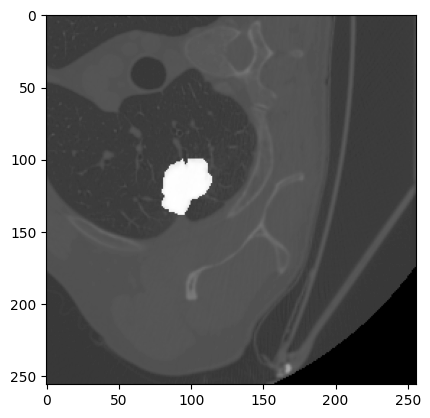

In [ ]:
from tqdm import tqdm
for idx, img_mask in enumerate(tqdm(train_loader)):
    img = img_mask[0].float()
    mask = img_mask[1].float()
    plt.imshow(mask[1].T+img[1].T, cmap='gray')
    break

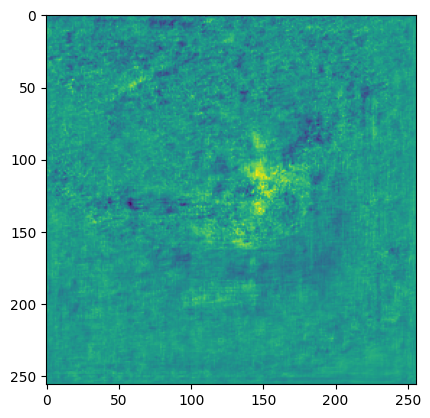

In [ ]:
plt.imshow(output[0].T)

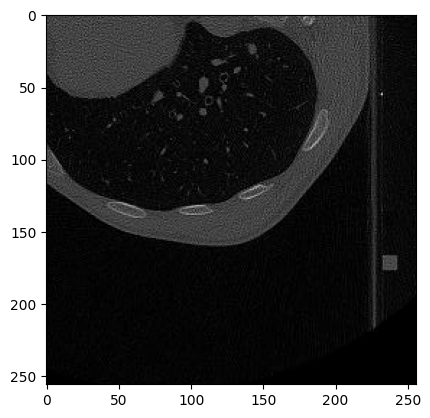

In [ ]:
plt.imshow(images[0].T)

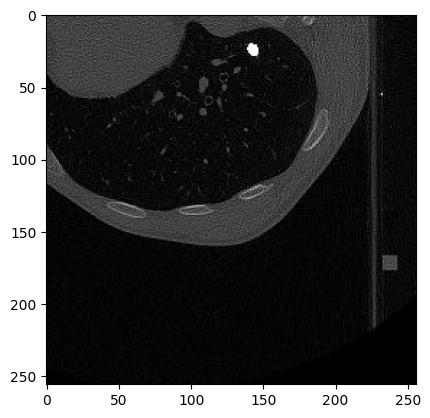

In [ ]:
plt.imshow(masks[0].T+images[0].T)

# **PreTrained Models**

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

In [ ]:
with torch.no_grad():
    output = model(images)['out'][0]

In [ ]:
output_pred = output.argmax(0)
output_pred

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
output_pred.shape

torch.Size([256, 256])

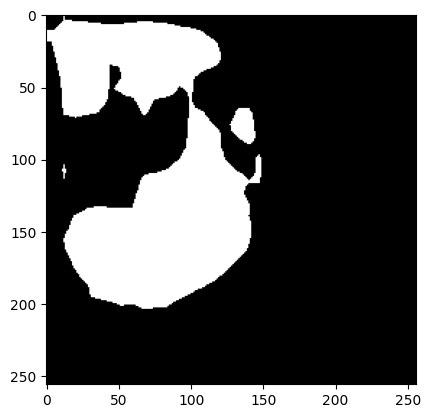

In [ ]:
plt.imshow(output_pred, cmap='gray')

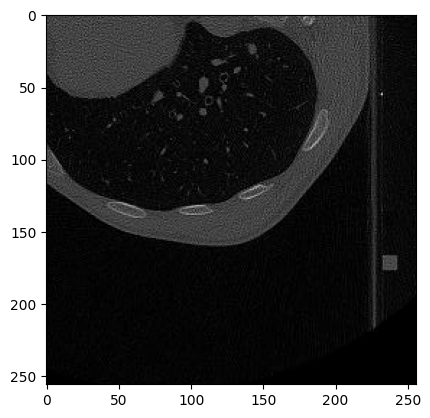

In [ ]:
plt.imshow(images[0].T)

In [ ]:
# !pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-soy9s94s
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-soy9s94s
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit b081758e5e6cd1125e97b31e1fb3819aa1575e47
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
^C


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [ ]:
with torch.no_grad():
    output = model(images)
# output

In [ ]:
output.shape

torch.Size([32, 1, 256, 256])

In [ ]:
output[0]

tensor([[[-0.4396, -0.6129, -0.4421,  ..., -0.0652, -0.0349, -0.4158],
         [ 0.0825, -0.5130, -1.0286,  ..., -0.3530, -0.4563, -0.3063],
         [ 0.5325, -2.1272, -1.0746,  ..., -0.3322, -0.2648, -0.1347],
         ...,
         [-0.1813, -0.7156, -0.0162,  ...,  0.2738, -0.0623, -0.5808],
         [-0.0098, -1.0283, -0.3612,  ...,  0.1090, -0.2474, -0.9078],
         [-0.0022, -0.5309, -0.5851,  ..., -0.1311, -0.3612, -0.1379]]])

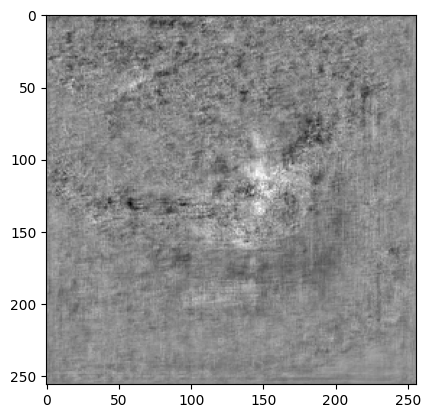

In [ ]:
plt.imshow(output[0].T, cmap='gray')